# IMPORTANT NOTE
---
Add our working folder in your drive by doing a **right-click** on the **shared folder (from the top-bar)** and choosing **"Add shortcut to Drive"** option

Link: https://drive.google.com/drive/folders/1WcmQZcp5bW37p4benYfhfSqeUQLkUJNQ?usp=sharing

# Installing requirements
---

In [1]:
!python3 -m pip install pmdarima

     |████████████████████████████████| 1.5MB 12.1MB/s 
     |████████████████████████████████| 2.1MB 43.9MB/s 
     |████████████████████████████████| 8.7MB 39.4MB/s 
     |████████████████████████████████| 808kB 47.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: setuptools 50.3.2
    Uninstalling setuptools-50.3.2:
      Successfully uninstalled setuptools-50.3.2


In [2]:
!python3 -m pip install --upgrade plotly

     |████████████████████████████████| 13.1MB 11.7MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [3]:
!python3 -m pip install geopandas

     |████████████████████████████████| 972kB 12.7MB/s 
     |████████████████████████████████| 6.5MB 33.8MB/s 
     |████████████████████████████████| 14.8MB 270kB/s 


# Imports
---

In [4]:
from pmdarima.arima import auto_arima
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
import plotly.express as px
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(True)
import json
import geopandas as gpd
from dateutil.parser import parse
import datetime
import ast

# Function definitions
---

In [5]:
def preprocess(path):
    
    district_data=pd.read_csv(path)
    district_data.drop(['State','District'],axis=1,inplace=True)
    district_data.set_index('Date',inplace=True)
    
    district_data=district_data.diff(1)
    
    district_data.drop([district_data.head(1).index[0],district_data.tail(1).index[0]],inplace=True)
    
    district_data.set_index(pd.DatetimeIndex(district_data.index),inplace=True)

    district_data.fillna(0, inplace=True)
    
    return district_data


def forecast_series(df):
    stepwise_fit = auto_arima(df, start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True)
    s = str(stepwise_fit)
    temp = []
    season = ""
    for i in range(len(s)):
        if(s[i].isdigit()):
            temp.append(s[i])
        if(s[i]=='['):
            j=i+1
            while(s[j]!=']'):
                season+=s[j]
                j+=1
            temp.append(season)
            break

    model = sm.tsa.statespace.SARIMAX(df, order = (int(temp[0]), int(temp[1]), int(temp[2])),seasonal_order =(int(temp[3]), int(temp[4]), int(temp[5]), int(temp[6])))
    result = model.fit() 
    forecast = result.predict(start = len(df),end = (len(df)-1) + 10 * 12, typ = 'levels').rename('Forecast') 

    return forecast


def visualize(df,forecast):
    df['Confirmed'].plot()
    forecast.plot()


def forecast_and_export(districts,input_path,output_path,column='Confirmed'):
    
    INPUT_BASE=input_path
    OUTPUT_BASE=output_path
    for district_file in districts:
        print("Processing "+district_file)
        district_data=preprocess(INPUT_BASE+district_file)
        district_forecast=forecast_series(district_data[column])
        
        district_forecast.to_csv(OUTPUT_BASE+district_file)

def train_test_split(df, test_split_ratio=0.2):
    num_samples=df.shape[0]
    return df.iloc[:int(num_samples*(1-test_split_ratio))],df.iloc[int(num_samples*(1-test_split_ratio)):]

def MAPE(y_pred, y_true):
    
    mape=0.0
    den=0
    for yp,yt in zip(y_pred,y_true):
        if yt!=0:
            mape += abs((yt-yp)/yt)
            den += 1
    if den==0:
        return 0
    return mape/den

def export_test_score(districts,input_path,output_path):

    INPUT_BASE=input_path
    OUTPUT_BASE=output_path

    test_scores=pd.DataFrame(columns=["District","MAPE"])

    for district_file in districts:
        try:
            print("Processing "+district_file)
            district_data=preprocess(INPUT_BASE+district_file)

            train,test=train_test_split(district_data)

            test_forecast=forecast_series(train['Confirmed'])

            test_forecast.to_csv(OUTPUT_BASE + district_file)

            test_size=test.shape[0]
            mape=MAPE(test_forecast[:test_size].values,test['Confirmed'].values)

            test_scores=test_scores.append({
                "District": district_file[:-4],
                "MAPE": mape
            },ignore_index=True)
        except:
            pass

    test_scores.to_csv(OUTPUT_BASE+'test_scores.csv')


In [ ]:
def max_tested(district):
  df = preprocess(district)
  return df['Tested'].values.max()

def mean_tested(district):
  df = preprocess(district)
  return df['Tested'].values.mean()

def tested(district):
  return preprocess(district)['Tested'].values

def forecast_for_all(input_path, districts):
  forecasts={}
  for district in tqdm(districts):
    try:
      forecast=pd.read_csv(input_path+district)
      forecasts[district] = np.around(forecast['Forecast'].values).astype(np.int)
    except:
      pass
  return forecasts

def getOffset(forecasts, offset):
  res = {}
  for k,v in forecasts.items():
    res[k] = v[offset]
  return res

def maxTested(forecasts, input_path):
  res = {}
  for k in tqdm(forecasts.keys()):
    res[k] = max_tested(input_path + k)
  return res

def meanTested(forecasts, input_path):
  res = {}
  for k in tqdm(forecasts.keys()):
    res[k] = mean_tested(input_path + k)
  return res

# Important paths
---

In [6]:
BASE='/content/drive/My Drive/DS250_Project/Dataset/'
input_path=BASE+'Districts/'
output_path=BASE+'Forecasts/'
test_forecast_path=BASE+'Test Forecasts/'

# Exporting forecasts and their test scores (MAPE)
---

In [ ]:
districts=os.listdir(input_path)
districts.sort()
districts_cleaned=[s for s in districts if s.split('-')[1]!='Unknown.csv']

In [ ]:
export_test_score(districts_cleaned,input_path,output_path)

Processing Tamil Nadu-Perambalur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1386.814, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1359.212, Time=0.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1355.447, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1384.842, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1382.993, Time=0.23 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=4.22 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1367.584, Time=0.66 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=6.65 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1370.714, Time=0.41 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=3.68 sec
 ARIMA(0,0,1)(0,1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Pudukkottai.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1726.883, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1610.936, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1679.888, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1605.422, Time=0.75 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.34 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1665.285, Time=0.54 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1600.249, Time=1.15 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1606.949, Time=0.37 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=7.55 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1602.165, Time=1.29 sec
 ARIMA(2,1,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Railway Quarantine.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1088.985, Time=1.22 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1130.538, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1107.405, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1100.495, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1130.119, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1130.727, Time=0.17 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1088.653, Time=1.34 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1101.701, Time=0.65 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=1089.450, Time=2.95 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=1089.785, Time=4.80 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1087.952, Time=2.77 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1102.228, Time=1.73 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=1100.733, Time=1.34 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Ramanathapuram.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.86 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1708.499, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1611.833, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1649.740, Time=0.74 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1706.591, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1678.141, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1602.634, Time=2.37 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.16 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.57 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1688.642, Time=1.93 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1588.564, Time=4.96 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1601.036, Time=1.28 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.39 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.42 sec
 AR

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Ranipet.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1981.872, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1924.397, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1954.739, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1917.446, Time=0.88 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1948.108, Time=0.58 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1895.830, Time=1.17 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1910.103, Time=0.45 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.11 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1875.516, Time=1.41 sec
 ARIMA(3,1,0)(1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Salem.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2049.127, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1894.610, Time=1.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2050.395, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1955.944, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1881.690, Time=4.26 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.05 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2029.690, Time=2.58 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1845.874, Time=6.51 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1863.576, Time=2.13 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.09 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.85 sec
 ARIMA(3,0,0)(2,1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Sivaganga.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1658.232, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1583.160, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1634.422, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1569.936, Time=0.71 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.50 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1601.971, Time=0.55 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1537.861, Time=1.09 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1553.768, Time=0.45 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.11 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.69 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1534.561, Time=1.22 sec
 ARIMA(3,1,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Tenkasi.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1716.299, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1673.288, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1682.643, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1653.481, Time=0.83 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1689.926, Time=0.59 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1640.620, Time=0.89 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1659.759, Time=0.40 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.06 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.49 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1634.098, Time=1.29 sec
 ARIMA(3,1,0)(1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Thanjavur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1912.592, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1740.108, Time=1.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1911.821, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1801.673, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1727.250, Time=4.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1889.204, Time=2.42 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1717.573, Time=5.08 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1736.920, Time=1.82 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.40 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.71 sec
 ARIMA(3,0,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Theni.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1845.676, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1761.589, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.40 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1839.296, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1748.313, Time=0.84 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1749.411, Time=0.50 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1732.521, Time=1.11 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1747.034, Time=0.46 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.64 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1728.920, Time=1.23 sec
 ARIMA(3,1,0)(1,1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing Tamil Nadu-Thiruvallur.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2013.221, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1904.000, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1944.841, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1887.176, Time=0.90 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.79 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1959.257, Time=0.61 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1873.583, Time=1.29 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1890.869, Time=0.44 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.54 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1873.601, Time=1.28 sec
 ARIMA(2,1,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Thiruvarur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1758.618, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1676.407, Time=0.95 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1758.422, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1725.874, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1670.368, Time=2.90 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.39 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1743.853, Time=1.85 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1662.081, Time=3.63 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1670.921, Time=1.25 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(3,0,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Thoothukkudi.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1980.107, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1783.485, Time=0.84 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1893.868, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1978.380, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1802.947, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1779.211, Time=3.21 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.78 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1970.848, Time=1.53 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1763.882, Time=4.21 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1770.647, Time=1.29 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=10.05 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.48 sec
 ARI

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Tiruchirappalli.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1691.159, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1632.810, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1664.616, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1623.550, Time=0.77 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.30 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1641.142, Time=0.56 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1619.118, Time=1.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1626.432, Time=0.41 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.37 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1610.718, Time=1.25 sec
 ARIMA(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Tirunelveli.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1941.992, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1854.384, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1902.637, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1833.341, Time=0.83 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.71 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1875.269, Time=0.59 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1824.885, Time=1.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1844.605, Time=0.47 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.07 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1826.424, Time=1.10 sec
 ARIMA(2,1,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Tirupathur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1551.018, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1515.386, Time=0.87 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1520.385, Time=1.34 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1552.619, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1543.506, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1516.686, Time=2.76 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.20 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1535.697, Time=0.62 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1488.809, Time=1.16 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=1525.465, Time=0.24 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1490.328, Time=2.99 sec
 A

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Tiruppur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1825.314, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1745.168, Time=1.02 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1768.416, Time=1.02 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1829.599, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1766.413, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1737.171, Time=2.56 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.00 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1822.901, Time=2.42 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1730.219, Time=2.94 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1742.054, Time=0.98 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.93 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(3,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing Tamil Nadu-Tiruvannamalai.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1928.234, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1875.290, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1898.191, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1852.799, Time=0.83 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.79 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1888.204, Time=0.66 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1847.086, Time=1.13 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1870.097, Time=0.39 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.69 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1835.671, Time=1.42 sec
 ARIMA(3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Vellore.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1917.584, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1846.110, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1880.185, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1793.171, Time=0.88 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.82 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1839.045, Time=0.60 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1778.802, Time=1.24 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1829.804, Time=0.47 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.45 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.40 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1776.200, Time=1.39 sec
 ARIMA(3,1,0)(1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Viluppuram.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1767.805, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1702.055, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1749.902, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1691.173, Time=0.81 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.48 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1707.520, Time=0.55 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1686.009, Time=1.07 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1697.180, Time=0.42 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.19 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1687.488, Time=1.19 sec
 ARIMA(2,1,1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tamil Nadu-Virudhunagar.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2112.430, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2018.833, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2065.575, Time=0.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2110.481, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2039.967, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1998.410, Time=2.63 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.90 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2111.319, Time=1.68 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1952.276, Time=5.38 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1976.973, Time=1.32 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.82 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.00 sec
 ARIM

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tripura-Dhalai.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1563.130, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1486.911, Time=0.95 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1561.131, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1518.503, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1477.668, Time=2.66 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1551.334, Time=1.76 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1476.097, Time=3.19 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1487.633, Time=1.11 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.45 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(3,0,0)(2,1,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tripura-Gomati.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1515.667, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1473.129, Time=0.84 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1514.004, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1485.188, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1467.009, Time=2.46 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.57 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1509.821, Time=1.84 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1444.916, Time=3.08 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1451.926, Time=0.91 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.25 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(3,0,0)(2,1,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tripura-Khowai.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1271.587, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1252.284, Time=0.60 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1269.602, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1273.528, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1241.278, Time=2.24 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.17 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1245.508, Time=1.39 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1215.654, Time=2.24 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1240.031, Time=0.93 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.50 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(3,0,0)(2,1,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tripura-North Tripura.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1454.593, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1382.480, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1452.740, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1413.577, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1368.827, Time=2.20 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.82 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1436.735, Time=1.58 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1347.296, Time=3.20 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1369.669, Time=0.99 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.80 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.15 sec
 ARIMA(3,0,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tripura-Sipahijala.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1368.454, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1322.278, Time=0.73 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1366.454, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1345.449, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1307.996, Time=2.28 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1329.039, Time=1.42 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1280.890, Time=2.23 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1298.834, Time=1.05 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.55 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(3,0,0)(2

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tripura-South Tripura.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1232.574, Time=1.77 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1339.427, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1301.478, Time=0.76 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1338.645, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1296.978, Time=0.30 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1234.573, Time=2.51 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1234.573, Time=5.10 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1261.308, Time=1.01 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=1236.295, Time=7.25 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1272.060, Time=0.83 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1232.507, Time=1.97 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=1297.072, Time=0.44 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=1234.485, T

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tripura-Unokoti.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1302.990, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1266.817, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1301.679, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1293.274, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1268.373, Time=1.79 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.94 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1288.919, Time=0.61 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1258.705, Time=0.97 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=1295.237, Time=0.25 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1258.840, Time=2.62 sec
 ARIMA(2,0,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Tripura-West Tripura.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1574.373, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1523.811, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1566.032, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1507.237, Time=0.77 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.30 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1519.923, Time=0.58 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1501.320, Time=1.09 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1518.516, Time=0.41 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.31 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1493.368, Time=1.29 sec
 ARIMA(3,1,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Agra.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.81 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1676.423, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1589.980, Time=0.87 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1674.560, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1622.200, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1586.975, Time=2.47 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.65 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1672.014, Time=2.10 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1562.059, Time=3.53 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1566.270, Time=1.24 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.62 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(3,0,0)(2

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Aligarh.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1643.795, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1535.723, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1497.826, Time=0.98 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1563.459, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=2.09 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=4.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1530.089, Time=0.28 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=6.61 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1570.069, Time=0.40 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=1.82 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.38 sec

Best model:  ARIMA(0,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Ambedkar Nagar.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.65 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1262.139, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1162.651, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1180.801, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1147.674, Time=0.61 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.49 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.37 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1209.229, Time=0.47 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1135.608, Time=0.90 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1152.504, Time=0.33 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.94 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1131.158, Time=0.99 sec
 ARIM

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Amethi.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1444.005, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1396.495, Time=0.78 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1442.251, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1433.655, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1385.268, Time=2.11 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.69 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1412.940, Time=1.72 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1334.049, Time=2.63 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1360.318, Time=1.02 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.06 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(3,0,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Amroha.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1520.792, Time=1.30 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1552.256, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1533.082, Time=0.89 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1519.143, Time=0.95 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1553.148, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1551.582, Time=0.26 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=4.85 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1532.920, Time=0.76 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=6.97 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1519.528, Time=0.45 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1520.723, Time=1.59 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1519.398, Time=0.77 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1522.682, Time=1.38 se

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Auraiya.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1455.540, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1417.638, Time=0.78 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1454.017, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1447.632, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1402.710, Time=2.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.51 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1434.039, Time=1.64 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1387.905, Time=3.22 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1407.038, Time=1.10 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.61 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.09 sec
 ARIMA(3,0,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Ayodhya.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1699.842, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1597.321, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1646.829, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1582.789, Time=0.63 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.40 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1634.286, Time=0.52 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1576.659, Time=1.03 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1593.119, Time=0.39 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.09 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1572.261, Time=1.18 sec
 ARIMA(3,1,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Azamgarh.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.28 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1643.047, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1591.383, Time=0.88 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1604.289, Time=0.94 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1641.445, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1625.457, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1584.905, Time=2.54 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.76 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1632.303, Time=1.97 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1563.724, Time=3.17 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1572.226, Time=1.19 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.84 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.10 sec
 ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Baghpat.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.64 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1326.581, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1277.574, Time=0.65 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1324.891, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1324.126, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1259.715, Time=1.80 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.67 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1265.902, Time=1.51 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1250.117, Time=2.55 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1268.322, Time=0.90 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.58 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.74 sec
 ARIMA(3,0,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Bahraich.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1513.830, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1462.212, Time=0.84 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1479.161, Time=0.92 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1512.229, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1493.683, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1447.619, Time=2.56 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.90 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1507.941, Time=1.88 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1417.934, Time=3.55 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1435.550, Time=1.03 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.80 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=1401.418, Time=1.90 sec
 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Ballia.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1645.536, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1554.738, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1590.113, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1543.997, Time=0.75 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1599.799, Time=0.56 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1542.635, Time=1.02 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1550.437, Time=0.35 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.88 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1538.635, Time=1.17 sec
 ARIMA(3,1,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Balrampur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.78 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1390.098, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1345.272, Time=0.71 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1388.302, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1386.554, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1337.243, Time=2.18 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.32 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1359.926, Time=1.48 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1329.682, Time=2.65 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1341.673, Time=0.97 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.75 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.89 sec
 ARIMA(3,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Processing Uttar Pradesh-Banda.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1460.542, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1409.865, Time=0.74 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1400.302, Time=0.91 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1459.812, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1446.393, Time=0.26 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=4.15 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1421.364, Time=0.66 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=6.82 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1390.220, Time=1.72 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=1447.498, Time=0.39 sec
 ARIMA(0,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(0,0,2)(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Barabanki.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1507.007, Time=0.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1643.319, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1566.266, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1505.053, Time=0.65 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1578.054, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.96 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1542.817, Time=0.30 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.68 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1570.041, Time=0.29 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1507.010, Time=1.11 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1526.540, Time=0.52 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1508.232, Time=1.94 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1505.715, Time=0.92

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Bareilly.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.82 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1878.070, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1802.961, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1837.047, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1783.546, Time=0.78 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1832.836, Time=0.62 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1739.876, Time=1.12 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1752.891, Time=0.42 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.70 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1727.593, Time=1.29 sec
 ARIMA(3,1,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Basti.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1767.488, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1684.441, Time=0.91 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1765.791, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1727.059, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1666.067, Time=2.62 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1713.243, Time=2.24 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1661.758, Time=3.31 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1680.059, Time=1.34 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.05 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(3,0,0)(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Bhadohi.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1441.618, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1388.899, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1439.727, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1432.758, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1371.041, Time=2.07 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.13 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1388.893, Time=1.58 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1371.737, Time=2.61 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1364.599, Time=3.00 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1384.596, Time=0.97 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=7.94 sec
 ARIMA(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Bijnor.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1497.280, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1459.622, Time=0.83 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1495.686, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1483.487, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1450.370, Time=2.26 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.33 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1485.797, Time=1.55 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1433.973, Time=3.20 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1447.715, Time=1.01 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.10 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(3,0,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Processing Uttar Pradesh-Budaun.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1518.319, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1495.830, Time=0.83 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1500.933, Time=0.84 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1516.598, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1506.713, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1491.667, Time=2.45 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.00 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1512.505, Time=1.60 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1436.321, Time=3.30 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1450.919, Time=0.81 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.14 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.95 sec
 ARIMA(3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Bulandshahr.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1514.792, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1473.448, Time=0.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1514.171, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1510.333, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1467.788, Time=2.40 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.86 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.05 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1475.654, Time=1.66 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1445.598, Time=2.62 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1457.191, Time=1.03 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.24 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Chandauli.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1531.816, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1438.697, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1475.692, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1428.962, Time=0.71 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.50 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.72 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1483.869, Time=0.59 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1412.018, Time=0.90 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1420.932, Time=0.33 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.78 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1393.165, Time=1.23 sec
 ARIMA(3,1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Chitrakoot.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1248.442, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1215.026, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1248.496, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1245.548, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1207.859, Time=1.81 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.63 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1215.847, Time=1.35 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1188.335, Time=2.51 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1203.965, Time=0.94 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.62 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(3,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Uttar Pradesh-Deoria.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1623.023, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1489.864, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1558.637, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1486.335, Time=0.79 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.33 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1551.769, Time=0.57 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1463.245, Time=1.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1468.233, Time=0.38 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=6.52 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.46 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1464.856, Time=1.21 sec
 ARIMA(2,1,1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Etah.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.89 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1401.508, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1372.156, Time=1.15 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1399.796, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1400.799, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1366.004, Time=4.20 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1379.096, Time=1.64 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1343.947, Time=2.97 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1358.577, Time=0.74 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.04 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.74 sec
 ARIMA(3,0,0)(2

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Etawah.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1589.915, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1548.300, Time=0.85 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1558.861, Time=1.02 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1588.553, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1571.309, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1542.283, Time=2.36 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.68 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1583.157, Time=1.81 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1507.521, Time=3.39 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1520.467, Time=0.79 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.77 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.30 sec
 ARIMA(3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Farrukhabad.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1562.354, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1468.575, Time=0.80 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1560.557, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1493.391, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1429.248, Time=2.79 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.78 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1499.418, Time=2.46 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1396.168, Time=3.95 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1433.246, Time=0.88 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.93 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Fatehpur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1406.116, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1365.183, Time=0.68 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1404.829, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1398.452, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1348.962, Time=2.24 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.68 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1356.727, Time=1.47 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1350.606, Time=2.99 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1339.276, Time=3.31 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1366.620, Time=1.27 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=1320.323, Time=7.27 sec
 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Firozabad.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.81 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1416.062, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1377.961, Time=0.71 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1386.345, Time=0.82 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1414.063, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1390.945, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1370.635, Time=1.91 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.34 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1416.596, Time=1.71 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1359.014, Time=2.87 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1369.325, Time=1.16 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.22 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.63 sec
 ARIM

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Gautam Buddha Nagar.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1844.152, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1819.547, Time=1.01 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1847.427, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1834.966, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1805.995, Time=3.02 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.84 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1826.759, Time=2.02 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1800.044, Time=4.19 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1817.319, Time=1.15 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.72 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.94 sec


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Ghaziabad.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1889.364, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1829.266, Time=1.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1890.927, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1847.579, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1821.797, Time=3.07 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.74 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1883.290, Time=2.10 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1806.578, Time=4.31 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1813.464, Time=1.48 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.67 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(3,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Ghazipur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1555.694, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1525.204, Time=0.84 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1533.909, Time=0.91 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1554.351, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1543.088, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1515.350, Time=2.37 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.03 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1552.006, Time=1.72 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1483.668, Time=3.06 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1501.825, Time=1.07 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.64 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.59 sec
 ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Gonda.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1611.480, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1553.973, Time=0.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1570.510, Time=0.99 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1609.964, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1582.822, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1550.087, Time=2.27 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1594.951, Time=1.58 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1531.532, Time=2.98 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1535.233, Time=1.08 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.23 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.95 sec
 ARIMA(3,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Gorakhpur.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2060.634, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1948.621, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1998.814, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1943.825, Time=0.98 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.84 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2005.077, Time=0.61 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1897.701, Time=1.23 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1899.049, Time=0.45 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.14 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.51 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1889.983, Time=1.43 sec
 ARIMA(3,1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Hamirpur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.67 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1175.264, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1143.513, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1173.600, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1168.085, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1132.332, Time=1.70 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1143.906, Time=1.33 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1134.331, Time=2.26 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1134.282, Time=5.10 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1132.603, Time=1.46 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1131.777, Time=4.03 sec
 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Hapur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1546.784, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1519.569, Time=0.82 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1544.941, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1546.805, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1510.831, Time=2.38 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.85 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1512.995, Time=1.96 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1509.224, Time=3.07 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1518.022, Time=1.24 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.10 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(3,0,0)(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Hardoi.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1482.025, Time=0.94 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1686.381, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1549.726, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1493.482, Time=0.74 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1569.425, Time=0.16 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1483.480, Time=2.20 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1483.642, Time=2.76 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1509.572, Time=0.44 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1484.739, Time=5.00 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1483.693, Time=1.69 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1482.180, Time=1.48 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1604.068, Time=0.29 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1480.243, Ti

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Hathras.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.86 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1212.566, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1180.675, Time=0.53 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1210.712, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1202.508, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1167.244, Time=1.89 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.68 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1190.652, Time=1.46 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1156.786, Time=2.09 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1174.644, Time=0.85 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.21 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(3,0,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Uttar Pradesh-Jalaun.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.02 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1503.778, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1444.679, Time=0.67 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1502.363, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1486.526, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1436.217, Time=2.28 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1458.281, Time=1.49 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1411.192, Time=2.80 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1420.735, Time=0.95 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.42 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(3,0,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Jaunpur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1736.500, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1691.671, Time=0.86 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1734.892, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1720.546, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1672.423, Time=2.82 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1711.281, Time=2.06 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1650.683, Time=3.52 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1669.873, Time=1.12 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(3,0,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Jhansi.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1767.594, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1673.159, Time=0.94 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1706.276, Time=1.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1765.852, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1717.490, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1661.979, Time=3.01 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.17 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1753.062, Time=1.97 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1632.984, Time=4.59 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1642.932, Time=1.57 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.34 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.87 sec
 ARIMA(3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Kannauj.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1538.582, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1478.736, Time=0.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1536.756, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1525.876, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1470.074, Time=2.32 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.70 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1493.825, Time=1.86 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1461.848, Time=2.74 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1470.432, Time=1.02 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.64 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.69 sec
 ARIMA(3,0,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Kanpur Dehat.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1514.135, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1404.474, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1452.762, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1393.155, Time=0.75 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.69 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1448.708, Time=0.52 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1351.500, Time=1.11 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1363.386, Time=0.37 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=6.58 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.43 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1337.314, Time=1.09 sec
 ARIMA(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Kanpur Nagar.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2015.300, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1922.411, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1991.918, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1911.615, Time=0.92 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.89 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1943.797, Time=0.55 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1889.707, Time=1.35 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1902.561, Time=0.49 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.86 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1888.507, Time=1.29 sec
 ARIMA(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Kasganj.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1271.537, Time=1.76 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1326.098, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1306.625, Time=0.71 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1296.318, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1325.119, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1317.223, Time=0.28 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=4.51 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1295.915, Time=0.79 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=6.40 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1292.490, Time=0.54 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=3.43 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1304.585, Time=0.34 sec
 ARIMA(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Kaushambi.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1329.590, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1292.725, Time=0.67 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1329.121, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1328.787, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1273.997, Time=2.07 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.04 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1287.823, Time=1.28 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1271.777, Time=2.65 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1293.515, Time=0.97 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.15 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(3,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Kushinagar.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1590.138, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1516.184, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1553.352, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1498.039, Time=0.73 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1526.790, Time=0.51 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1464.311, Time=1.12 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1481.097, Time=0.45 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=6.59 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.33 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1457.372, Time=1.18 sec
 ARIMA(3,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Lakhimpur Kheri.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1816.303, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1755.945, Time=0.91 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1815.643, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1794.222, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1744.449, Time=2.59 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1777.942, Time=2.35 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1714.825, Time=4.47 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1726.831, Time=0.89 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.26 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARI

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Lalitpur.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.65 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1360.254, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1295.731, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1313.169, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1261.288, Time=0.72 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.47 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1299.671, Time=0.48 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1263.210, Time=0.92 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1263.108, Time=1.49 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1255.623, Time=0.91 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1287.536, Time=0.28 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=3.88 sec
 ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Lucknow.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2241.619, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2194.908, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2224.862, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2180.836, Time=0.95 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.83 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2193.362, Time=0.73 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2159.092, Time=1.35 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2175.387, Time=0.47 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.88 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.62 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2154.040, Time=1.55 sec
 ARIMA(3,1,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Maharajganj.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1462.591, Time=1.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1576.188, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1534.670, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1460.696, Time=0.57 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1516.032, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=4.11 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1497.733, Time=0.29 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=5.71 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1524.084, Time=0.33 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1462.502, Time=1.37 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1498.607, Time=0.53 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1459.293, Time=1.18 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.43 se

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Mahoba.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1150.118, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1101.363, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1148.569, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1146.528, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1094.145, Time=1.68 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1102.241, Time=1.30 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1082.466, Time=2.23 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1091.698, Time=0.78 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.27 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.48 sec
 ARIMA(3,0,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Mainpuri.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.82 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1518.896, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1457.336, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1517.254, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1480.204, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1434.389, Time=2.43 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.91 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1492.017, Time=1.84 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1428.215, Time=3.11 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1456.470, Time=1.12 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.11 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(3,0,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing Uttar Pradesh-Mathura.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.82 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1597.719, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1564.692, Time=0.76 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1597.107, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1598.809, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1562.859, Time=2.44 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.00 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1571.993, Time=2.07 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1554.434, Time=2.98 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1559.896, Time=1.20 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.16 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.12 sec
 ARIMA(3,0,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Mau.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1467.195, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1413.382, Time=0.73 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1409.671, Time=0.84 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1465.507, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1449.533, Time=0.21 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=4.55 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1420.912, Time=0.67 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=6.11 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1440.975, Time=0.46 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(0,0,1)(0,1,1)[

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Meerut.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.05 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1799.594, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1726.738, Time=1.04 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1775.579, Time=1.31 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1801.942, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1760.533, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1726.736, Time=2.28 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1803.209, Time=1.85 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1666.683, Time=4.49 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1672.063, Time=1.62 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.51 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.44 sec
 ARIMA(3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to conve

Processing Uttar Pradesh-Mirzapur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.69 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1596.095, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1551.557, Time=0.80 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1594.362, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1594.017, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1530.151, Time=2.55 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.78 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1544.475, Time=2.08 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1530.196, Time=3.17 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1521.582, Time=3.29 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1545.977, Time=1.13 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=6.60 sec
 ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Moradabad.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1747.439, Time=2.19 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1861.879, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1798.924, Time=1.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1816.501, Time=1.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1860.679, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1842.479, Time=0.41 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1742.984, Time=3.05 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1762.234, Time=1.91 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=1744.176, Time=9.29 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=1743.715, Time=7.29 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1744.532, Time=7.34 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1751.962, Time=5.62 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=1745.772, Time=9.15 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1811

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing Uttar Pradesh-Muzaffarnagar.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1490.752, Time=0.89 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1714.103, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1573.716, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1504.327, Time=0.68 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1543.554, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=2.31 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=2.75 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1522.894, Time=0.44 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=3.25 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1491.988, Time=1.91 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1491.180, Time=1.23 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1489.192, Time=0.77 sec
 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Processing Uttar Pradesh-Pilibhit.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1598.788, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1516.070, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1579.327, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1499.305, Time=0.71 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.28 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1514.247, Time=0.53 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1472.670, Time=1.25 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1497.648, Time=0.43 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1466.150, Time=1.28 sec
 ARIMA(3,1,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Pratapgarh.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.30 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1619.755, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1546.148, Time=0.86 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1618.438, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1590.637, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1536.628, Time=2.65 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.33 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1602.157, Time=1.79 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1508.930, Time=4.55 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1522.427, Time=1.17 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.59 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(3,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Prayagraj.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1859.917, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1803.916, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1843.354, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1779.585, Time=0.88 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1755.537, Time=5.46 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=1757.521, Time=5.45 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=5.98 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.19 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.47 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=3.35 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.62 sec
 ARIMA(2,1,1)(2,1,1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Rae Bareli.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1528.336, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1453.969, Time=0.77 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1527.700, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1497.728, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1433.767, Time=2.18 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.88 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.28 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1470.646, Time=1.68 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1424.467, Time=3.09 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1449.693, Time=1.11 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.27 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(3,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Rampur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.78 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1714.990, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1651.149, Time=0.69 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1713.030, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1704.865, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1649.249, Time=2.09 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.51 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1704.309, Time=2.04 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1641.956, Time=3.40 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1645.766, Time=0.84 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.17 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(3,0,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Saharanpur.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1623.114, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1549.426, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1586.608, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1539.608, Time=0.91 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1596.188, Time=0.50 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1536.674, Time=1.07 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1547.113, Time=0.38 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.08 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1528.338, Time=1.11 sec
 ARIMA(3,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Sambhal.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1515.162, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1468.984, Time=0.63 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1513.514, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1517.088, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1464.165, Time=2.27 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.25 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1464.400, Time=1.69 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1465.983, Time=2.84 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1464.148, Time=4.81 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1469.373, Time=1.21 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=8.22 sec
 ARIMA(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Sant Kabir Nagar.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1472.699, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1408.202, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1431.259, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1370.359, Time=0.68 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.64 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1413.431, Time=0.54 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1357.149, Time=0.96 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1392.289, Time=0.38 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.85 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.41 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1341.817, Time=1.12 sec
 AR

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Shahjahanpur.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1810.530, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1751.532, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1787.599, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1733.143, Time=0.79 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.35 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1761.832, Time=0.59 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1689.526, Time=1.12 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1706.831, Time=0.41 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.85 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1658.684, Time=1.37 sec
 ARIMA(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Shamli.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1417.382, Time=2.01 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1518.591, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1496.413, Time=0.88 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1516.846, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1495.210, Time=0.40 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=5.08 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1456.480, Time=1.62 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=5.00 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1411.176, Time=1.66 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=1486.164, Time=0.42 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(2,0,1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Processing Uttar Pradesh-Shrawasti.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1203.825, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1162.631, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1201.956, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1184.936, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1148.830, Time=1.94 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.83 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1190.698, Time=1.34 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1134.824, Time=2.66 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1148.862, Time=0.79 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.89 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(3,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Siddharthnagar.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1431.486, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1393.790, Time=0.73 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1407.321, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1429.922, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1400.284, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1383.554, Time=2.13 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.30 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1429.888, Time=1.75 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1358.956, Time=3.11 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1377.603, Time=0.96 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.23 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.10 sec


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Sitapur.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1719.744, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1616.650, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1702.887, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1617.148, Time=0.80 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.32 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1632.676, Time=0.17 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1607.750, Time=0.42 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1683.220, Time=0.12 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1607.092, Time=1.29 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=7.69 sec
 ARIMA(2,1,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Sonbhadra.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1412.899, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1386.639, Time=0.67 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1412.375, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1414.479, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1376.003, Time=2.14 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.72 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1379.932, Time=1.62 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1353.525, Time=2.79 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1366.204, Time=0.96 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.61 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(3,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Sultanpur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1592.369, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1521.169, Time=0.81 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1590.988, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1556.225, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1516.716, Time=2.44 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.40 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1559.653, Time=1.77 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1506.622, Time=2.76 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1513.701, Time=1.17 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.24 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.02 sec
 ARIMA(3,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Unnao.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1573.903, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1482.172, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1543.621, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1470.607, Time=0.78 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1509.962, Time=0.51 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1458.516, Time=1.02 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1472.326, Time=0.39 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=6.79 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1433.964, Time=1.17 sec
 ARIMA(3,1,0)(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttar Pradesh-Varanasi.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1992.548, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1847.497, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.35 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1902.256, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1829.864, Time=0.86 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.72 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1903.487, Time=0.64 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1820.443, Time=1.23 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1839.057, Time=0.47 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.74 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1819.540, Time=1.54 sec
 ARIMA(3,1,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttarakhand-Almora.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1589.243, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1529.330, Time=0.81 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1587.407, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1572.641, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1502.057, Time=2.62 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.75 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1521.812, Time=1.99 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1483.298, Time=3.17 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1517.312, Time=1.23 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.35 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.64 sec
 ARIMA(3,0,0)(2

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttarakhand-Bageshwar.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1168.186, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1134.921, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1166.596, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1170.160, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1124.545, Time=1.83 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.46 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1122.568, Time=1.41 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1132.979, Time=0.49 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.41 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1124.550, Time=1.58 sec
 ARIMA(1,0,1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttarakhand-Chamoli.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1241.808, Time=1.23 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1288.548, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1244.872, Time=0.71 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1240.299, Time=0.70 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1288.148, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1284.754, Time=0.20 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.28 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=4.16 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1244.885, Time=0.59 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1243.933, Time=3.16 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1238.648, Time=0.41 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1242.964, Time=0.47 sec
 ARI

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttarakhand-Champawat.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1152.600, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1139.111, Time=0.65 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1150.998, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1151.162, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1123.806, Time=1.69 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.57 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1126.655, Time=1.29 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1124.816, Time=2.13 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1123.505, Time=3.00 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1141.108, Time=1.02 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=6.95 sec
 ARIMA(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttarakhand-Dehradun.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2125.516, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2014.003, Time=0.84 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2124.148, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2063.193, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1997.206, Time=2.43 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.21 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2119.698, Time=2.41 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1985.880, Time=7.41 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=2006.119, Time=1.32 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.05 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(3,0,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttarakhand-Haridwar.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1949.625, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1878.467, Time=0.65 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1947.902, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1913.188, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1866.835, Time=3.22 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.87 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1930.936, Time=2.43 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1846.312, Time=4.81 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1864.696, Time=1.02 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.80 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(3,0,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttarakhand-Nainital.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1803.293, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1786.391, Time=1.04 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1774.736, Time=1.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1802.010, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1802.617, Time=0.21 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=4.97 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1790.655, Time=0.80 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=3.90 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1764.509, Time=0.89 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1800.746, Time=0.14 sec
 ARIMA(1,0,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttarakhand-Pauri Garhwal.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1474.599, Time=1.50 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1547.708, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1508.566, Time=0.88 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1501.495, Time=0.70 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1548.124, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1523.773, Time=0.32 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.93 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=6.59 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1502.237, Time=1.05 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=5.76 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1492.453, Time=0.64 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1476.599, Time=2.06 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1476.599, Time=1.98 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1520.761, Time=0.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttarakhand-Pithoragarh.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1252.035, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1201.433, Time=0.69 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1250.364, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1244.830, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1190.069, Time=1.85 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.54 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1214.999, Time=1.43 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1187.722, Time=2.22 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1201.653, Time=1.00 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.36 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(3,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttarakhand-Rudraprayag.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1122.271, Time=2.96 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1195.169, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1144.694, Time=0.64 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1126.474, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1194.895, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1198.322, Time=0.36 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1123.091, Time=2.57 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=6.05 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1142.291, Time=1.31 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=1124.487, Time=6.16 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1126.376, Time=0.65 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1123.728, Time=3.27 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=3.16 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1124.992, Time

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Uttarakhand-Tehri Garhwal.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1488.408, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1444.827, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1486.518, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1489.684, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1425.085, Time=2.51 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.41 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1432.982, Time=1.67 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1424.467, Time=3.14 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1446.409, Time=1.12 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.60 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing Uttarakhand-Udham Singh Nagar.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1998.278, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1955.482, Time=1.04 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1996.359, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1982.955, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1945.091, Time=2.91 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.77 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.44 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1979.842, Time=2.41 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1931.452, Time=3.99 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1945.347, Time=1.08 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.48 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.63 sec
 ARI

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Processing Uttarakhand-Uttarkashi.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1413.627, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1396.028, Time=0.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1412.226, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1414.816, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1386.684, Time=2.22 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.83 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.09 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1393.043, Time=1.63 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1388.270, Time=3.08 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1377.780, Time=4.19 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1391.821, Time=1.69 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=6.79 sec
 ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Alipurduar.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1384.054, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1317.766, Time=0.73 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1383.784, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1352.643, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1318.575, Time=2.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.05 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.78 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1366.546, Time=0.61 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1312.344, Time=1.05 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=1350.737, Time=0.18 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1310.925, Time=2.87 sec
 ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Bankura.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1377.516, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1328.210, Time=0.83 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1383.144, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1357.233, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1301.755, Time=2.52 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.95 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1368.484, Time=1.85 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1286.745, Time=3.44 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1320.543, Time=0.97 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.73 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(3,0,0)(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Birbhum.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1577.693, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1518.918, Time=0.95 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1582.157, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1558.550, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1507.009, Time=2.37 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.12 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1531.397, Time=1.71 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1508.624, Time=3.21 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1507.806, Time=3.37 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1511.037, Time=2.04 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1508.154, Time=7.02 sec
 ARI

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Cooch Behar.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1382.632, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1313.110, Time=0.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1385.653, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1328.995, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1305.560, Time=2.05 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.86 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1362.313, Time=1.62 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1299.531, Time=2.65 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1308.634, Time=0.94 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.22 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(3,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Dakshin Dinajpur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1593.193, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1488.463, Time=0.78 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1592.404, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1543.759, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1476.034, Time=2.79 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.87 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1553.584, Time=1.87 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1473.475, Time=3.85 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1487.138, Time=1.35 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.36 sec
 ARIM

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Darjeeling.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1689.490, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1640.556, Time=0.91 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1702.699, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1684.447, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1625.163, Time=2.82 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.63 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1642.218, Time=1.72 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1622.285, Time=3.75 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1639.897, Time=1.42 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.44 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(3,0,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Hooghly.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1760.823, Time=2.24 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1853.833, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1794.661, Time=1.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1775.928, Time=1.31 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1862.799, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1831.931, Time=0.36 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.83 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1793.618, Time=1.30 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=5.71 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1764.379, Time=1.77 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1761.220, Time=2.56 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1760.943, Time=3.53 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARI

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Howrah.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.98 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1862.016, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1808.028, Time=0.81 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1873.120, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1838.072, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1804.870, Time=3.27 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.71 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1862.656, Time=2.37 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1788.874, Time=4.17 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1795.563, Time=1.42 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.68 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(3,0,0)(2

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Jalpaiguri.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1682.376, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1638.778, Time=0.88 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1691.955, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1676.816, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1626.891, Time=2.74 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.70 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1645.029, Time=1.80 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1625.451, Time=3.61 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1636.036, Time=1.28 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(3,0,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Jhargram.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=997.571, Time=0.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1112.320, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1040.368, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=996.136, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1061.633, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=997.815, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=997.851, Time=1.47 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1014.215, Time=0.23 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=999.327, Time=2.19 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1049.078, Time=0.27 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=997.552, Time=0.65 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1020.071, Time=0.45 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=998.651, Time=0.86 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=997.556, Time=

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Kalimpong.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1249.830, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1186.153, Time=0.63 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1249.108, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1218.607, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1173.811, Time=2.00 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.30 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1202.768, Time=1.43 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1134.115, Time=2.18 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1156.120, Time=0.79 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.69 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(3,0,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Kolkata.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.87 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2154.547, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2022.107, Time=1.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2092.956, Time=1.41 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2185.990, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2032.362, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2018.098, Time=2.53 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.45 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2131.557, Time=2.50 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1984.307, Time=5.19 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1988.102, Time=1.73 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.98 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(3,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Malda.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1676.264, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1607.877, Time=0.84 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1680.197, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1641.095, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1598.506, Time=2.35 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1630.226, Time=2.02 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1581.863, Time=3.18 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1592.299, Time=1.15 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.01 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(3,0,0)(2,

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Murshidabad.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.69 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1621.889, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1554.475, Time=0.86 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1630.083, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1585.888, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1550.884, Time=2.34 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1604.837, Time=2.09 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1544.894, Time=2.95 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1548.823, Time=1.23 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.67 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(3,0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Nadia.csv
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1531.649, Time=1.00 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1687.864, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1598.815, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1530.221, Time=0.67 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1603.173, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1567.637, Time=0.34 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=4.27 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1531.631, Time=0.90 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1532.168, Time=1.50 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.99 sec

Best model:  AR

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-North 24 Parganas.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2086.358, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1948.128, Time=1.15 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2022.421, Time=1.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2136.697, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1972.511, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1931.003, Time=3.90 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.10 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2085.837, Time=1.88 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1921.353, Time=5.29 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1936.511, Time=1.77 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.10 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.77 sec

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Other State.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=413.216, Time=1.12 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=551.289, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=440.784, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=442.925, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=549.475, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=467.408, Time=0.22 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=414.938, Time=1.81 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=414.782, Time=3.44 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=440.566, Time=0.77 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=415.447, Time=5.76 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=417.513, Time=0.58 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=413.795, Time=2.62 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=413.160, Time=1.63 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=465.876, Time=0.3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Paschim Bardhaman.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1656.602, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1614.602, Time=0.94 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1624.891, Time=0.96 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1667.160, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1641.378, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1603.213, Time=2.56 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1647.845, Time=2.03 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1579.605, Time=3.41 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1596.208, Time=1.20 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.27 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.87 sec

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Processing West Bengal-Paschim Medinipur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1855.595, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1760.377, Time=1.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1859.481, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1806.489, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1755.599, Time=3.15 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.89 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1836.223, Time=1.95 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1751.838, Time=4.18 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1760.375, Time=0.93 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.76 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.82 sec
 ARI

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Purba Bardhaman.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1580.913, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1535.788, Time=0.87 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1595.898, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1582.112, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1528.008, Time=2.43 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.30 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1547.949, Time=1.84 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1506.777, Time=2.96 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1513.520, Time=1.28 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.35 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Purba Medinipur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1794.443, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1738.044, Time=0.91 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1759.712, Time=0.91 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1800.682, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1752.830, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1734.297, Time=3.21 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1790.712, Time=2.14 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1715.250, Time=3.21 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1718.998, Time=0.94 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.43 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.96 sec
 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Purulia.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1322.701, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1267.371, Time=0.63 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1324.775, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1286.813, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1244.794, Time=2.31 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.37 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1308.313, Time=1.68 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1239.860, Time=2.79 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1263.556, Time=1.02 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.94 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(3,0,0)(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-South 24 Parganas.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1781.852, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1730.521, Time=0.93 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1742.737, Time=1.02 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1807.023, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1742.565, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1725.244, Time=2.91 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1773.373, Time=2.44 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1698.759, Time=3.72 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1707.724, Time=1.27 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.90 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.84 sec

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Processing West Bengal-Uttar Dinajpur.csv
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1501.255, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1434.545, Time=0.69 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1500.704, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1491.965, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1420.213, Time=2.10 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.64 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1433.600, Time=1.46 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1407.425, Time=2.97 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1428.435, Time=0.99 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.75 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


# Computing scores for each district to determine upcoming clusters
---

## Importing population data
---

In [ ]:
population_india = pd.read_csv(os.path.join(BASE, 'population_india.csv'))
population_india.drop(['District code','State name','Male','Female'],axis=1,inplace=True)
population_india.head()

,District name,Population
0,Kupwara,870354
1,Badgam,753745
2,Leh(Ladakh),133487
3,Kargil,140802
4,Punch,476835


In [ ]:
district_names = [d[:-4] for d in os.listdir(output_path)]
a = set(population_india['District name'])
districts_name_cleaned = [d.split('-')[1] for d in district_names]
b = set(districts_name_cleaned)
common_district_set = a.intersection(b)
common_districts={d+'.csv':d.split('-')[1] for d in district_names if d.split('-')[1] in common_district_set}

In [ ]:
populations = dict()
df = population_india
for i in range(df.shape[0]):
  populations[df.iloc[i]['District name']] = df.iloc[i]['Population']

## Loading forecasts
---

In [ ]:
forecasts_district=os.listdir(output_path)
district_names = [f[:-4] for f in forecasts_district]
f = forecast_for_all(output_path, forecasts_district)

100%|██████████| 652/652 [09:19<00:00,  1.16it/s]


In [ ]:
tests_mean = meanTested(f, input_path)

100%|██████████| 652/652 [09:18<00:00,  1.17it/s]


## Scoring function 1
---

$$ score(district, date) = \frac{forecast(district, date)}{population(district) \times tests(district, date)}$$

In [ ]:
forecast_df_1 = pd.DataFrame(f, columns=forecasts_district)
forecast_df_1[forecast_df_1 < 0] = 0

for k, v in tests_mean.items():
  if v>0:
    forecast_df_1[k] /= v
  else:
    forecast_df_1[k] = None

for i in range(forecast_df_1.shape[0]):
  forecast_df_1.iloc[i]=forecast_df_1.iloc[i].fillna(forecast_df_1.iloc[i].mean())

forecast_df_1.head()

,Jammu and Kashmir-Kishtwar.csv,Jammu and Kashmir-Kulgam.csv,Jammu and Kashmir-Kupwara.csv,Jammu and Kashmir-Pulwama.csv,Jammu and Kashmir-Punch.csv,Jammu and Kashmir-Rajouri.csv,Jammu and Kashmir-Ramban.csv,Jammu and Kashmir-Reasi.csv,Jammu and Kashmir-Samba.csv,Jammu and Kashmir-Shopiyan.csv,Jammu and Kashmir-Srinagar.csv,Jammu and Kashmir-Udhampur.csv,Jharkhand-Bokaro.csv,Jharkhand-Chatra.csv,Jharkhand-Deoghar.csv,Jharkhand-Dhanbad.csv,Jharkhand-Dumka.csv,Jharkhand-East Singhbhum.csv,Jharkhand-Garhwa.csv,Jharkhand-Giridih.csv,Jharkhand-Godda.csv,Jharkhand-Gumla.csv,Jharkhand-Hazaribagh.csv,Jharkhand-Jamtara.csv,Jharkhand-Khunti.csv,Jharkhand-Koderma.csv,Jharkhand-Latehar.csv,Jharkhand-Lohardaga.csv,Jharkhand-Pakur.csv,Jharkhand-Palamu.csv,Jharkhand-Ramgarh.csv,Jharkhand-Ranchi.csv,Jharkhand-Sahibganj.csv,Jharkhand-Saraikela-Kharsawan.csv,Jharkhand-Simdega.csv,Jharkhand-West Singhbhum.csv,Karnataka-Bagalkote.csv,Karnataka-Ballari.csv,Karnataka-Belagavi.csv,Karnataka-Bengaluru Rural.csv,...,Haryana-Fatehabad.csv,Haryana-Foreign Evacuees.csv,Haryana-Gurugram.csv,Haryana-Hisar.csv,Haryana-Italians.csv,Haryana-Jhajjar.csv,Haryana-Jind.csv,Haryana-Kaithal.csv,Haryana-Karnal.csv,Haryana-Kurukshetra.csv,Haryana-Mahendragarh.csv,Haryana-Nuh.csv,Haryana-Palwal.csv,Haryana-Panchkula.csv,Haryana-Panipat.csv,Haryana-Rewari.csv,Haryana-Rohtak.csv,Haryana-Sirsa.csv,Haryana-Sonipat.csv,Haryana-Yamunanagar.csv,Himachal Pradesh-Bilaspur.csv,Himachal Pradesh-Chamba.csv,Himachal Pradesh-Hamirpur.csv,Himachal Pradesh-Kangra.csv,Himachal Pradesh-Kinnaur.csv,Himachal Pradesh-Kullu.csv,Himachal Pradesh-Lahaul and Spiti.csv,Himachal Pradesh-Mandi.csv,Himachal Pradesh-Shimla.csv,Himachal Pradesh-Sirmaur.csv,Himachal Pradesh-Solan.csv,Himachal Pradesh-Una.csv,Jammu and Kashmir-Anantnag.csv,Jammu and Kashmir-Bandipora.csv,Jammu and Kashmir-Baramulla.csv,Jammu and Kashmir-Budgam.csv,Jammu and Kashmir-Doda.csv,Jammu and Kashmir-Ganderbal.csv,Jammu and Kashmir-Jammu.csv,Jammu and Kashmir-Kathua.csv
0,1.16632,1.16632,1.16632,0.018954,1.16632,1.16632,1.16632,1.16632,1.16632,1.16632,1.16632,1.16632,2.742588,1.16632,0.453431,1.16632,1.382857,1.16632,1.16632,0.164371,0.167567,1.16632,1.16632,1.371088,1.16632,1.16632,1.16632,0.000000,0.769868,1.16632,1.16632,1.16632,0.000000,1.16632,1.16632,1.16632,0.185598,0.037261,0.059015,0.251209,...,0.159491,1.16632,0.223193,0.178206,1.16632,0.079393,5.138889,2.450331,0.019015,0.032721,1.16632,0.077624,0.062219,0.093691,0.019608,0.192687,9.102091,5.687161,0.134393,0.000000,0.092952,0.144974,0.104316,0.112092,0.071152,0.542209,30.25,0.414292,0.567661,0.051773,0.030601,0.055207,1.16632,1.16632,1.16632,1.16632,1.16632,1.16632,1.16632,1.16632
1,2.42436,2.42436,2.42436,0.048738,2.42436,2.42436,2.42436,2.42436,2.42436,2.42436,2.42436,2.42436,1.433625,2.42436,5.441176,2.42436,0.628571,2.42436,2.42436,0.000000,0.636753,2.42436,2.42436,2.193741,2.42436,2.42436,2.42436,0.804153,0.085541,2.42436,2.42436,2.42436,0.698151,2.42436,2.42436,2.42436,0.206220,0.000000,0.000000,0.372482,...,0.129587,2.42436,0.226803,0.144332,2.42436,0.061750,6.540404,0.000000,0.000000,0.109711,2.42436,0.354852,0.099551,0.048357,0.050981,0.079051,7.167897,4.572031,0.065558,0.000000,0.099148,0.039538,0.066383,0.076863,0.213456,0.885608,18.15,0.617376,0.591314,0.073962,0.122403,0.063094,2.42436,2.42436,2.42436,2.42436,2.42436,2.42436,2.42436,2.42436
2,1.62451,1.62451,1.62451,0.046031,1.62451,1.62451,1.62451,1.62451,1.62451,1.62451,1.62451,1.62451,2.929582,1.62451,4.761029,1.62451,1.131429,1.62451,1.62451,0.123279,0.402160,1.62451,1.62451,1.919523,1.62451,1.62451,1.62451,0.709547,0.256623,1.62451,1.62451,1.62451,0.000000,1.62451,1.62451,1.62451,0.189722,0.133520,0.000000,0.374647,...,0.269142,1.62451,0.229811,0.169369,1.62451,0.072336,23.358586,0.000000,0.016298,0.096238,1.62451,0.077624,0.080885,0.063468,0.011765,0.459484,8.305658,5.575648,0.252396,4.049248,0.086755,0.171333,0.113799,0.121700,0.213456,0.578357,12.10,0.446785,0.272004,0.110942,0.146884,0.055207

In [ ]:
forecast_df_1_reduced = forecast_df_1[common_districts.keys()].copy()
forecast_df_1_reduced.head()

,Jammu and Kashmir-Kishtwar.csv,Jammu and Kashmir-Kulgam.csv,Jammu and Kashmir-Kupwara.csv,Jammu and Kashmir-Pulwama.csv,Jammu and Kashmir-Punch.csv,Jammu and Kashmir-Rajouri.csv,Jammu and Kashmir-Ramban.csv,Jammu and Kashmir-Reasi.csv,Jammu and Kashmir-Samba.csv,Jammu and Kashmir-Srinagar.csv,Jammu and Kashmir-Udhampur.csv,Jharkhand-Bokaro.csv,Jharkhand-Chatra.csv,Jharkhand-Deoghar.csv,Jharkhand-Dhanbad.csv,Jharkhand-Dumka.csv,Jharkhand-Garhwa.csv,Jharkhand-Giridih.csv,Jharkhand-Godda.csv,Jharkhand-Gumla.csv,Jharkhand-Hazaribagh.csv,Jharkhand-Jamtara.csv,Jharkhand-Khunti.csv,Jharkhand-Latehar.csv,Jharkhand-Lohardaga.csv,Jharkhand-Pakur.csv,Jharkhand-Palamu.csv,Jharkhand-Ramgarh.csv,Jharkhand-Ranchi.csv,Jharkhand-Sahibganj.csv,Jharkhand-Simdega.csv,Karnataka-Bidar.csv,Karnataka-Chikkaballapura.csv,Karnataka-Chitradurga.csv,Karnataka-Dakshina Kannada.csv,Karnataka-Davanagere.csv,Karnataka-Dharwad.csv,Karnataka-Gadag.csv,Karnataka-Hassan.csv,Karnataka-Haveri.csv,...,Gujarat-Surat.csv,Gujarat-Surendranagar.csv,Gujarat-Tapi.csv,Gujarat-Vadodara.csv,Gujarat-Valsad.csv,Haryana-Ambala.csv,Haryana-Bhiwani.csv,Haryana-Faridabad.csv,Haryana-Fatehabad.csv,Haryana-Hisar.csv,Haryana-Jhajjar.csv,Haryana-Jind.csv,Haryana-Kaithal.csv,Haryana-Karnal.csv,Haryana-Kurukshetra.csv,Haryana-Mahendragarh.csv,Haryana-Palwal.csv,Haryana-Panchkula.csv,Haryana-Panipat.csv,Haryana-Rewari.csv,Haryana-Rohtak.csv,Haryana-Sirsa.csv,Haryana-Sonipat.csv,Haryana-Yamunanagar.csv,Himachal Pradesh-Bilaspur.csv,Himachal Pradesh-Chamba.csv,Himachal Pradesh-Hamirpur.csv,Himachal Pradesh-Kangra.csv,Himachal Pradesh-Kinnaur.csv,Himachal Pradesh-Kullu.csv,Himachal Pradesh-Mandi.csv,Himachal Pradesh-Shimla.csv,Himachal Pradesh-Sirmaur.csv,Himachal Pradesh-Solan.csv,Himachal Pradesh-Una.csv,Jammu and Kashmir-Anantnag.csv,Jammu and Kashmir-Doda.csv,Jammu and Kashmir-Ganderbal.csv,Jammu and Kashmir-Jammu.csv,Jammu and Kashmir-Kathua.csv
0,1.16632,1.16632,1.16632,0.018954,1.16632,1.16632,1.16632,1.16632,1.16632,1.16632,1.16632,2.742588,1.16632,0.453431,1.16632,1.382857,1.16632,0.164371,0.167567,1.16632,1.16632,1.371088,1.16632,1.16632,0.000000,0.769868,1.16632,1.16632,1.16632,0.000000,1.16632,0.00872,2.777655,16.081451,0.064757,83.892454,0.033458,1.467241,5.731849,0.000000,...,0.047762,0.030059,0.006450,0.059241,0.002374,0.040263,4.928952,0.178306,0.159491,0.178206,0.079393,5.138889,2.450331,0.019015,0.032721,1.16632,0.062219,0.093691,0.019608,0.192687,9.102091,5.687161,0.134393,0.000000,0.092952,0.144974,0.104316,0.112092,0.071152,0.542209,0.414292,0.567661,0.051773,0.030601,0.055207,1.16632,1.16632,1.16632,1.16632,1.16632
1,2.42436,2.42436,2.42436,0.048738,2.42436,2.42436,2.42436,2.42436,2.42436,2.42436,2.42436,1.433625,2.42436,5.441176,2.42436,0.628571,2.42436,0.000000,0.636753,2.42436,2.42436,2.193741,2.42436,2.42436,0.804153,0.085541,2.42436,2.42436,2.42436,0.698151,2.42436,0.00000,1.021197,19.626968,0.124996,0.000000,0.129468,0.000000,5.328829,0.379384,...,0.046886,0.031828,0.016125,0.059241,0.004748,0.048315,3.614565,0.170700,0.129587,0.144332,0.061750,6.540404,0.000000,0.000000,0.109711,2.42436,0.099551,0.048357,0.050981,0.079051,7.167897,4.572031,0.065558,0.000000,0.099148,0.039538,0.066383,0.076863,0.213456,0.885608,0.617376,0.591314,0.073962,0.122403,0.063094,2.42436,2.42436,2.42436,2.42436,2.42436
2,1.62451,1.62451,1.62451,0.046031,1.62451,1.62451,1.62451,1.62451,1.62451,1.62451,1.62451,2.929582,1.62451,4.761029,1.62451,1.131429,1.62451,0.123279,0.402160,1.62451,1.62451,1.919523,1.62451,1.62451,0.709547,0.256623,1.62451,1.62451,1.62451,0.000000,1.62451,0.00872,1.960698,14.815195,0.156621,98.924542,0.114921,0.765517,5.821410,0.862237,...,0.046886,0.024755,0.009675,0.057640,0.007122,0.052342,10.350799,0.163095,0.269142,0.169369,0.072336,23.358586,0.000000,0.016298,0.096238,1.62451,0.080885,0.063468,0.011765,0.459484,8.305658,5.575648,0.252396,4.049248,0.086755,0.171333,0.113799,0.121700,0.213456,0.578357,0.446785,0.272004,0.110942,0.146884,0.055207,1.62451,1.62451,1

In [ ]:
forecast_df_1_reduced *= 1000   # To increase the magnitudes
for dist in forecast_df_1_reduced.columns:
  forecast_df_1_reduced[dist] /= populations[common_districts[dist]]

In [ ]:
forecast_df_1_reduced.head()

,Jammu and Kashmir-Kishtwar.csv,Jammu and Kashmir-Kulgam.csv,Jammu and Kashmir-Kupwara.csv,Jammu and Kashmir-Pulwama.csv,Jammu and Kashmir-Punch.csv,Jammu and Kashmir-Rajouri.csv,Jammu and Kashmir-Ramban.csv,Jammu and Kashmir-Reasi.csv,Jammu and Kashmir-Samba.csv,Jammu and Kashmir-Srinagar.csv,Jammu and Kashmir-Udhampur.csv,Jharkhand-Bokaro.csv,Jharkhand-Chatra.csv,Jharkhand-Deoghar.csv,Jharkhand-Dhanbad.csv,Jharkhand-Dumka.csv,Jharkhand-Garhwa.csv,Jharkhand-Giridih.csv,Jharkhand-Godda.csv,Jharkhand-Gumla.csv,Jharkhand-Hazaribagh.csv,Jharkhand-Jamtara.csv,Jharkhand-Khunti.csv,Jharkhand-Latehar.csv,Jharkhand-Lohardaga.csv,Jharkhand-Pakur.csv,Jharkhand-Palamu.csv,Jharkhand-Ramgarh.csv,Jharkhand-Ranchi.csv,Jharkhand-Sahibganj.csv,Jharkhand-Simdega.csv,Karnataka-Bidar.csv,Karnataka-Chikkaballapura.csv,Karnataka-Chitradurga.csv,Karnataka-Dakshina Kannada.csv,Karnataka-Davanagere.csv,Karnataka-Dharwad.csv,Karnataka-Gadag.csv,Karnataka-Hassan.csv,Karnataka-Haveri.csv,...,Gujarat-Surat.csv,Gujarat-Surendranagar.csv,Gujarat-Tapi.csv,Gujarat-Vadodara.csv,Gujarat-Valsad.csv,Haryana-Ambala.csv,Haryana-Bhiwani.csv,Haryana-Faridabad.csv,Haryana-Fatehabad.csv,Haryana-Hisar.csv,Haryana-Jhajjar.csv,Haryana-Jind.csv,Haryana-Kaithal.csv,Haryana-Karnal.csv,Haryana-Kurukshetra.csv,Haryana-Mahendragarh.csv,Haryana-Palwal.csv,Haryana-Panchkula.csv,Haryana-Panipat.csv,Haryana-Rewari.csv,Haryana-Rohtak.csv,Haryana-Sirsa.csv,Haryana-Sonipat.csv,Haryana-Yamunanagar.csv,Himachal Pradesh-Bilaspur.csv,Himachal Pradesh-Chamba.csv,Himachal Pradesh-Hamirpur.csv,Himachal Pradesh-Kangra.csv,Himachal Pradesh-Kinnaur.csv,Himachal Pradesh-Kullu.csv,Himachal Pradesh-Mandi.csv,Himachal Pradesh-Shimla.csv,Himachal Pradesh-Sirmaur.csv,Himachal Pradesh-Solan.csv,Himachal Pradesh-Una.csv,Jammu and Kashmir-Anantnag.csv,Jammu and Kashmir-Doda.csv,Jammu and Kashmir-Ganderbal.csv,Jammu and Kashmir-Jammu.csv,Jammu and Kashmir-Kathua.csv
0,0.00505566,0.00274763,0.00134005,0.000034,0.00244596,0.00181552,0.00411092,0.00370652,0.00365735,0.000942992,0.00210153,0.001330,0.00111836,0.000304,0.000434467,0.001046,0.000881716,0.000067,0.000128,0.00113764,0.000672426,0.001733,0.00219281,0.00160434,0.000000,0.000855,0.000601237,0.00122843,0.000400212,0.000000,0.00194524,0.000005,0.002213,0.009691,0.000031,0.043121,0.000018,0.001378,0.003227,0.000000,...,0.000008,0.000017,0.000008,0.000014,0.000001,0.000036,0.003016,0.000099,0.000169,0.000102,0.000083,0.003852,0.002281,0.000013,0.000034,0.00126487,0.000060,0.000167,0.000016,0.000214,0.008577,0.004391,0.000093,0.000000,0.000035,0.000279,0.000094,0.000074,0.000846,0.001238,0.000414,0.000697,0.000098,0.000053,0.000106,0.00108124,0.00284513,0.00392112,0.000762322,0.00189204
1,0.0105089,0.00571133,0.00278549,0.000087,0.00508428,0.00377382,0.00854512,0.00770453,0.00760231,0.00196014,0.00436834,0.000695,0.00232467,0.003647,0.000903101,0.000476,0.00183277,0.000000,0.000485,0.00236474,0.00139773,0.002773,0.00455806,0.00333485,0.001741,0.000095,0.00124976,0.00255346,0.000831898,0.000607,0.00404345,0.000000,0.000814,0.011827,0.000060,0.000000,0.000070,0.000000,0.003000,0.000237,...,0.000008,0.000018,0.000020,0.000014,0.000003,0.000043,0.002211,0.000094,0.000138,0.000083,0.000064,0.004902,0.000000,0.000000,0.000114,0.00262921,0.000095,0.000086,0.000042,0.000088,0.006754,0.003530,0.000045,0.000000,0.000037,0.000076,0.000060,0.000051,0.002537,0.002022,0.000618,0.000726,0.000140,0.000211,0.000121,0.0022475,0.005914,0.00815059,0.00158459,0.00393287
2,0.00704179,0.00382704,0.0018665,0.000082,0.00340687,0.00252876,0.0057259,0.00516264,0.00509415,0.00131345,0.00292713,0.001421,0.00155771,0.003191,0.000605148,0.000856,0.0012281,0.000050,0.000306,0.00158456,0.000936591,0.002427,0.00305426,0.00223461,0.001537,0.000285,0.000837434,0.00171102,0.000557437,0.000000,0.00270943,0.000005,0.001562,0.008928,0.000075,0.050848,0.000062,0.000719,0.003277,0.000540,...,0.000008,0.000014,0.000012,0.000014,0.000004,0.000046,0.006333,0.000090,0.000286,0.000097,0.000075,0.017

In [ ]:
forecast_df_1_reduced.to_csv(os.path.join(BASE, 'forecast_scores_1.csv'), index=False)

## Scoring function 2
---

$$ score(district, date) = \frac{forecast(district, date)}{\sqrt{population(district) \times tests(district, date)}}$$

In [ ]:
forecast_df_2 = pd.DataFrame(f, columns=forecasts_district)
forecast_df_2[forecast_df_2 < 0] = 0

for k, v in tests_mean.items():
  if v>0:
    forecast_df_2[k] /= np.sqrt(v)
  else:
    forecast_df_2[k] = None

for i in range(forecast_df_2.shape[0]):
  forecast_df_2.iloc[i]=forecast_df_2.iloc[i].fillna(forecast_df_2.iloc[i].mean())

forecast_df_2.head()

,Jammu and Kashmir-Kishtwar.csv,Jammu and Kashmir-Kulgam.csv,Jammu and Kashmir-Kupwara.csv,Jammu and Kashmir-Pulwama.csv,Jammu and Kashmir-Punch.csv,Jammu and Kashmir-Rajouri.csv,Jammu and Kashmir-Ramban.csv,Jammu and Kashmir-Reasi.csv,Jammu and Kashmir-Samba.csv,Jammu and Kashmir-Shopiyan.csv,Jammu and Kashmir-Srinagar.csv,Jammu and Kashmir-Udhampur.csv,Jharkhand-Bokaro.csv,Jharkhand-Chatra.csv,Jharkhand-Deoghar.csv,Jharkhand-Dhanbad.csv,Jharkhand-Dumka.csv,Jharkhand-East Singhbhum.csv,Jharkhand-Garhwa.csv,Jharkhand-Giridih.csv,Jharkhand-Godda.csv,Jharkhand-Gumla.csv,Jharkhand-Hazaribagh.csv,Jharkhand-Jamtara.csv,Jharkhand-Khunti.csv,Jharkhand-Koderma.csv,Jharkhand-Latehar.csv,Jharkhand-Lohardaga.csv,Jharkhand-Pakur.csv,Jharkhand-Palamu.csv,Jharkhand-Ramgarh.csv,Jharkhand-Ranchi.csv,Jharkhand-Sahibganj.csv,Jharkhand-Saraikela-Kharsawan.csv,Jharkhand-Simdega.csv,Jharkhand-West Singhbhum.csv,Karnataka-Bagalkote.csv,Karnataka-Ballari.csv,Karnataka-Belagavi.csv,Karnataka-Bengaluru Rural.csv,...,Haryana-Fatehabad.csv,Haryana-Foreign Evacuees.csv,Haryana-Gurugram.csv,Haryana-Hisar.csv,Haryana-Italians.csv,Haryana-Jhajjar.csv,Haryana-Jind.csv,Haryana-Kaithal.csv,Haryana-Karnal.csv,Haryana-Kurukshetra.csv,Haryana-Mahendragarh.csv,Haryana-Nuh.csv,Haryana-Palwal.csv,Haryana-Panchkula.csv,Haryana-Panipat.csv,Haryana-Rewari.csv,Haryana-Rohtak.csv,Haryana-Sirsa.csv,Haryana-Sonipat.csv,Haryana-Yamunanagar.csv,Himachal Pradesh-Bilaspur.csv,Himachal Pradesh-Chamba.csv,Himachal Pradesh-Hamirpur.csv,Himachal Pradesh-Kangra.csv,Himachal Pradesh-Kinnaur.csv,Himachal Pradesh-Kullu.csv,Himachal Pradesh-Lahaul and Spiti.csv,Himachal Pradesh-Mandi.csv,Himachal Pradesh-Shimla.csv,Himachal Pradesh-Sirmaur.csv,Himachal Pradesh-Solan.csv,Himachal Pradesh-Una.csv,Jammu and Kashmir-Anantnag.csv,Jammu and Kashmir-Bandipora.csv,Jammu and Kashmir-Baramulla.csv,Jammu and Kashmir-Budgam.csv,Jammu and Kashmir-Doda.csv,Jammu and Kashmir-Ganderbal.csv,Jammu and Kashmir-Jammu.csv,Jammu and Kashmir-Kathua.csv
0,4.77835,4.77835,4.77835,0.364248,4.77835,4.77835,4.77835,4.77835,4.77835,4.77835,4.77835,4.77835,10.985165,4.77835,0.952293,4.77835,3.900183,4.77835,4.77835,0.810855,0.915332,4.77835,4.77835,2.618289,4.77835,4.77835,4.77835,0.000000,2.632263,4.77835,4.77835,4.77835,0.000000,4.77835,4.77835,4.77835,2.889967,1.337367,1.943435,5.398167,...,1.597455,4.77835,9.099705,4.643591,4.77835,1.890158,7.518496,4.427488,0.364833,0.745825,4.77835,0.737135,1.115521,1.704234,0.313115,2.741310,26.984575,17.030714,2.347362,0.000000,1.180794,1.262820,1.071204,1.980713,0.266743,4.033147,12.298374,4.596615,5.219937,0.602006,0.391157,0.621652,4.77835,4.77835,4.77835,4.77835,4.77835,4.77835,4.77835,4.77835
1,3.77932,3.77932,3.77932,0.936638,3.77932,3.77932,3.77932,3.77932,3.77932,3.77932,3.77932,3.77932,5.742245,3.77932,11.427521,3.77932,1.772811,3.77932,3.77932,0.000000,3.478262,3.77932,3.77932,4.189263,3.77932,3.77932,3.77932,3.697379,0.292474,3.77932,3.77932,3.77932,2.210668,3.77932,3.77932,3.77932,3.211075,0.000000,0.000000,8.004178,...,1.297932,3.77932,9.246870,3.760925,3.77932,1.470123,9.568995,0.000000,0.000000,2.500707,3.77932,3.369758,1.784834,0.879605,0.814100,1.124640,21.250353,13.691358,1.145055,0.000000,1.259514,0.344405,0.681675,1.358203,0.800230,6.587474,7.379024,6.849858,5.437434,0.860009,1.564628,0.710460,3.77932,3.77932,3.77932,3.77932,3.77932,3.77932,3.77932,3.77932
2,5.26433,5.26433,5.26433,0.884602,5.26433,5.26433,5.26433,5.26433,5.26433,5.26433,5.26433,5.26433,11.734154,5.26433,9.999081,5.26433,3.191059,5.26433,5.26433,0.608141,2.196797,5.26433,5.26433,3.665605,5.26433,5.26433,5.26433,3.262393,0.877421,5.26433,5.26433,5.26433,0.000000,5.26433,5.26433,5.26433,2.954189,4.792231,0.000000,8.050714,...,2.695705,5.26433,9.369508,4.413330,5.26433,1.722144,34.174981,0.000000,0.312714,2.193603,5.26433,0.737135,1.450178,1.154481,0.187869,6.536969,24.623425,16.696778,4.408460,8.049097,1.102074,1.492423,1.168586,2.150488,0.800230,4.302024,4.919350,4.957134,2.501220,1.29001

In [ ]:
forecast_df_2_reduced = forecast_df_2[common_districts.keys()].copy()
forecast_df_2_reduced.head()

,Jammu and Kashmir-Kishtwar.csv,Jammu and Kashmir-Kulgam.csv,Jammu and Kashmir-Kupwara.csv,Jammu and Kashmir-Pulwama.csv,Jammu and Kashmir-Punch.csv,Jammu and Kashmir-Rajouri.csv,Jammu and Kashmir-Ramban.csv,Jammu and Kashmir-Reasi.csv,Jammu and Kashmir-Samba.csv,Jammu and Kashmir-Srinagar.csv,Jammu and Kashmir-Udhampur.csv,Jharkhand-Bokaro.csv,Jharkhand-Chatra.csv,Jharkhand-Deoghar.csv,Jharkhand-Dhanbad.csv,Jharkhand-Dumka.csv,Jharkhand-Garhwa.csv,Jharkhand-Giridih.csv,Jharkhand-Godda.csv,Jharkhand-Gumla.csv,Jharkhand-Hazaribagh.csv,Jharkhand-Jamtara.csv,Jharkhand-Khunti.csv,Jharkhand-Latehar.csv,Jharkhand-Lohardaga.csv,Jharkhand-Pakur.csv,Jharkhand-Palamu.csv,Jharkhand-Ramgarh.csv,Jharkhand-Ranchi.csv,Jharkhand-Sahibganj.csv,Jharkhand-Simdega.csv,Karnataka-Bidar.csv,Karnataka-Chikkaballapura.csv,Karnataka-Chitradurga.csv,Karnataka-Dakshina Kannada.csv,Karnataka-Davanagere.csv,Karnataka-Dharwad.csv,Karnataka-Gadag.csv,Karnataka-Hassan.csv,Karnataka-Haveri.csv,...,Gujarat-Surat.csv,Gujarat-Surendranagar.csv,Gujarat-Tapi.csv,Gujarat-Vadodara.csv,Gujarat-Valsad.csv,Haryana-Ambala.csv,Haryana-Bhiwani.csv,Haryana-Faridabad.csv,Haryana-Fatehabad.csv,Haryana-Hisar.csv,Haryana-Jhajjar.csv,Haryana-Jind.csv,Haryana-Kaithal.csv,Haryana-Karnal.csv,Haryana-Kurukshetra.csv,Haryana-Mahendragarh.csv,Haryana-Palwal.csv,Haryana-Panchkula.csv,Haryana-Panipat.csv,Haryana-Rewari.csv,Haryana-Rohtak.csv,Haryana-Sirsa.csv,Haryana-Sonipat.csv,Haryana-Yamunanagar.csv,Himachal Pradesh-Bilaspur.csv,Himachal Pradesh-Chamba.csv,Himachal Pradesh-Hamirpur.csv,Himachal Pradesh-Kangra.csv,Himachal Pradesh-Kinnaur.csv,Himachal Pradesh-Kullu.csv,Himachal Pradesh-Mandi.csv,Himachal Pradesh-Shimla.csv,Himachal Pradesh-Sirmaur.csv,Himachal Pradesh-Solan.csv,Himachal Pradesh-Una.csv,Jammu and Kashmir-Anantnag.csv,Jammu and Kashmir-Doda.csv,Jammu and Kashmir-Ganderbal.csv,Jammu and Kashmir-Jammu.csv,Jammu and Kashmir-Kathua.csv
0,4.77835,4.77835,4.77835,0.364248,4.77835,4.77835,4.77835,4.77835,4.77835,4.77835,4.77835,10.985165,4.77835,0.952293,4.77835,3.900183,4.77835,0.810855,0.915332,4.77835,4.77835,2.618289,4.77835,4.77835,0.000000,2.632263,4.77835,4.77835,4.77835,0.000000,4.77835,0.132061,13.743382,45.192303,1.668696,606.244870,0.877232,5.809178,27.086468,0.000000,...,3.226787,0.71485,0.113579,2.564326,0.048723,0.897362,12.160122,6.133715,1.597455,4.643591,1.890158,7.518496,4.427488,0.364833,0.745825,4.77835,1.115521,1.704234,0.313115,2.741310,26.984575,17.030714,2.347362,0.000000,1.180794,1.262820,1.071204,1.980713,0.266743,4.033147,4.596615,5.219937,0.602006,0.391157,0.621652,4.77835,4.77835,4.77835,4.77835,4.77835
1,3.77932,3.77932,3.77932,0.936638,3.77932,3.77932,3.77932,3.77932,3.77932,3.77932,3.77932,5.742245,3.77932,11.427521,3.77932,1.772811,3.77932,0.000000,3.478262,3.77932,3.77932,4.189263,3.77932,3.77932,3.697379,0.292474,3.77932,3.77932,3.77932,2.210668,3.77932,0.000000,5.052714,55.155961,3.220972,0.000000,3.394507,0.000000,25.181950,2.042848,...,3.167580,0.75690,0.283946,2.564326,0.097445,1.076834,8.917423,5.872088,1.297932,3.760925,1.470123,9.568995,0.000000,0.000000,2.500707,3.77932,1.784834,0.879605,0.814100,1.124640,21.250353,13.691358,1.145055,0.000000,1.259514,0.344405,0.681675,1.358203,0.800230,6.587474,6.849858,5.437434,0.860009,1.564628,0.710460,3.77932,3.77932,3.77932,3.77932,3.77932
2,5.26433,5.26433,5.26433,0.884602,5.26433,5.26433,5.26433,5.26433,5.26433,5.26433,5.26433,11.734154,5.26433,9.999081,5.26433,3.191059,5.26433,0.608141,2.196797,5.26433,5.26433,3.665605,5.26433,5.26433,3.262393,0.877421,5.26433,5.26433,5.26433,0.000000,5.26433,0.132061,9.701211,41.633854,4.035917,714.873544,3.013102,3.030876,27.509694,4.642836,...,3.167580,0.58870,0.170368,2.495020,0.146168,1.166570,25.536256,5.610460,2.695705,4.413330,1.722144,34.174981,0.000000,0.312714,2.193603,5.26433,1.450178,1.154481,0.187869,6.536969,24.623425,16.696778,4.408460,8.049097,1.102074,1.492423,1.168586,2.150488,0.800230,4.302024,4.957134,2.501220,1.290013,1.877554,0.621652,5

In [ ]:
forecast_df_2_reduced *= 1000   
for dist in forecast_df_2_reduced.columns:
  forecast_df_2_reduced[dist] /= populations[common_districts[dist]]

In [ ]:
forecast_df_2_reduced.head()

,Jammu and Kashmir-Kishtwar.csv,Jammu and Kashmir-Kulgam.csv,Jammu and Kashmir-Kupwara.csv,Jammu and Kashmir-Pulwama.csv,Jammu and Kashmir-Punch.csv,Jammu and Kashmir-Rajouri.csv,Jammu and Kashmir-Ramban.csv,Jammu and Kashmir-Reasi.csv,Jammu and Kashmir-Samba.csv,Jammu and Kashmir-Srinagar.csv,Jammu and Kashmir-Udhampur.csv,Jharkhand-Bokaro.csv,Jharkhand-Chatra.csv,Jharkhand-Deoghar.csv,Jharkhand-Dhanbad.csv,Jharkhand-Dumka.csv,Jharkhand-Garhwa.csv,Jharkhand-Giridih.csv,Jharkhand-Godda.csv,Jharkhand-Gumla.csv,Jharkhand-Hazaribagh.csv,Jharkhand-Jamtara.csv,Jharkhand-Khunti.csv,Jharkhand-Latehar.csv,Jharkhand-Lohardaga.csv,Jharkhand-Pakur.csv,Jharkhand-Palamu.csv,Jharkhand-Ramgarh.csv,Jharkhand-Ranchi.csv,Jharkhand-Sahibganj.csv,Jharkhand-Simdega.csv,Karnataka-Bidar.csv,Karnataka-Chikkaballapura.csv,Karnataka-Chitradurga.csv,Karnataka-Dakshina Kannada.csv,Karnataka-Davanagere.csv,Karnataka-Dharwad.csv,Karnataka-Gadag.csv,Karnataka-Hassan.csv,Karnataka-Haveri.csv,...,Gujarat-Surat.csv,Gujarat-Surendranagar.csv,Gujarat-Tapi.csv,Gujarat-Vadodara.csv,Gujarat-Valsad.csv,Haryana-Ambala.csv,Haryana-Bhiwani.csv,Haryana-Faridabad.csv,Haryana-Fatehabad.csv,Haryana-Hisar.csv,Haryana-Jhajjar.csv,Haryana-Jind.csv,Haryana-Kaithal.csv,Haryana-Karnal.csv,Haryana-Kurukshetra.csv,Haryana-Mahendragarh.csv,Haryana-Palwal.csv,Haryana-Panchkula.csv,Haryana-Panipat.csv,Haryana-Rewari.csv,Haryana-Rohtak.csv,Haryana-Sirsa.csv,Haryana-Sonipat.csv,Haryana-Yamunanagar.csv,Himachal Pradesh-Bilaspur.csv,Himachal Pradesh-Chamba.csv,Himachal Pradesh-Hamirpur.csv,Himachal Pradesh-Kangra.csv,Himachal Pradesh-Kinnaur.csv,Himachal Pradesh-Kullu.csv,Himachal Pradesh-Mandi.csv,Himachal Pradesh-Shimla.csv,Himachal Pradesh-Sirmaur.csv,Himachal Pradesh-Solan.csv,Himachal Pradesh-Una.csv,Jammu and Kashmir-Anantnag.csv,Jammu and Kashmir-Doda.csv,Jammu and Kashmir-Ganderbal.csv,Jammu and Kashmir-Jammu.csv,Jammu and Kashmir-Kathua.csv
0,0.0207128,0.0112569,0.00549013,0.000650,0.010021,0.00743811,0.0168422,0.0151854,0.014984,0.00386339,0.00860988,0.005327,0.00458186,0.000638,0.00177999,0.002951,0.00361235,0.000332,0.000697,0.00466084,0.0027549,0.003310,0.00898381,0.0065729,0.000000,0.002923,0.00246323,0.0050328,0.00163965,0.000000,0.00796953,0.000078,0.010950,0.027233,0.000799,0.311614,0.000475,0.005457,0.015248,0.000000,...,0.000531,0.000407,0.000141,0.000616,0.000029,0.000795,0.007440,0.003389,0.001696,0.002663,0.001972,0.005635,0.004121,0.000242,0.000773,0.0051821,0.001070,0.003036,0.000260,0.003045,0.025428,0.013149,0.001619,0.000000,0.000443,0.002433,0.000970,0.001312,0.003171,0.009210,0.004598,0.006413,0.001136,0.000674,0.001193,0.00442977,0.0116563,0.0160646,0.00312319,0.00775159
1,0.0163823,0.00890336,0.00434228,0.001671,0.00792585,0.00588299,0.0133209,0.0120105,0.0118512,0.00305566,0.00680978,0.002784,0.00362391,0.007659,0.00140784,0.001342,0.0028571,0.000000,0.002648,0.00368638,0.00217892,0.005296,0.00710553,0.00519868,0.008007,0.000325,0.00194824,0.00398057,0.00129684,0.001921,0.00630331,0.000000,0.004026,0.033237,0.001541,0.000000,0.001838,0.000000,0.014176,0.001279,...,0.000521,0.000431,0.000352,0.000616,0.000057,0.000954,0.005456,0.003245,0.001378,0.002157,0.001534,0.007172,0.000000,0.000000,0.002592,0.00409866,0.001712,0.001567,0.000675,0.001249,0.020025,0.010571,0.000790,0.000000,0.000473,0.000663,0.000617,0.000899,0.009513,0.015043,0.006851,0.006680,0.001623,0.002696,0.001363,0.00350362,0.0092193,0.0127059,0.00247021,0.00613094
2,0.0228193,0.0124017,0.00604849,0.001578,0.0110401,0.00819459,0.0185551,0.0167298,0.0165079,0.00425631,0.00948554,0.005690,0.00504785,0.006701,0.00196102,0.002415,0.00397973,0.000249,0.001672,0.00513486,0.00303508,0.004634,0.0098975,0.00724139,0.007065,0.000974,0.00271376,0.00554465,0.00180641,0.000000,0.00878006,0.000078,0.007729,0.025089,0.001931,0.367450,0.001631,0.002847,0.015486,0.002906,...,0.000521,0.000335,0.000211,0.000599,0.000086,0.001034,0.015624,0.003100,0.002862,0.002531,0.001797,0.025616,0.000000,0.000208,0.002274,0.0

In [ ]:
forecast_df_2_reduced.to_csv(os.path.join(BASE, 'forecast_scores_2.csv'), index=False)

# Predicting upcoming clusters (districts) based on score
---

In [38]:
def districtClustering(pair, eps=0.0175, min_samples=2):
  '''
    pair is a list of tuples like (district_name, district_score)
    pair =[(district_name_1, district_score_1),(district_name_2, district_score_2),...]
  '''
  sorted_pair=sorted(pair,key=lambda p: p[1],reverse=True)
  db_default = DBSCAN(eps = eps, min_samples = min_samples).fit(list([p[1]] for p in sorted_pair)) 
  labels = db_default.labels_ 
  ans=[]
  for i in range(len(labels)):
    if not labels[i]: # the districts with corresponding label=0 are considered as the cluster districts.
      ans.append(sorted_pair[i][0])
  return ans

def getPairs(df, offset):

  scores = df.iloc[offset]
  pairs = []
  for idx, dist in enumerate(df.columns):
    pairs.append((dist, scores[idx]))
  return pairs

In [36]:
scores1 = pd.read_csv(BASE + 'forecast_scores_1.csv')
scores2 = pd.read_csv(BASE + 'forecast_scores_2.csv')

### Visualising score using score vs rank plots
---



In [47]:
ranks = getPairs(scores1, 12)
ranks = sorted(ranks, reverse=True, key=lambda x:x[1])
px.scatter(ranks, y=1, x=list(range(len(ranks))), hover_name=0, labels={
    "1": "Score 1",
    "x": "Rank"
}).show()

### Number of districts as hotspot using score function 1
---


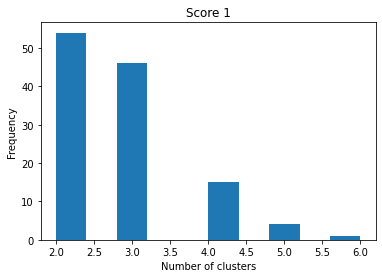

In [39]:
c1 = []
results1 = []
for i in range(scores1.shape[0]):
  dists = districtClustering(getPairs(scores1, i), 0.0009)
  results1.append(dists)
  c1.append(len(dists))
plt.hist(c1)
plt.title('Score 1')
plt.xlabel('Number of clusters')
plt.ylabel('Frequency')
plt.show()

### Number of districts as hotspot using score function 2
---


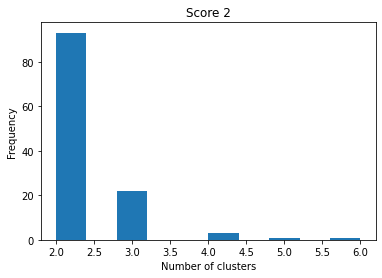

In [40]:
c2 = []
results2 = []
for i in range(scores2.shape[0]):
  dists = districtClustering(getPairs(scores2, i), 0.0009)
  results2.append(dists)
  c2.append(len(dists))
plt.hist(c2)
plt.title('Score 2')
plt.xlabel('Number of clusters')
plt.ylabel('Frequency')
plt.show()

In [ ]:
base_date = parse('30-10-2020')
upcoming_clusters = pd.DataFrame(columns=['Date','Districts'])
for i,rs in enumerate(zip(results1, results2)):
  r1,r2 = rs
  set1 = set(r1)
  set2 = set(r2)
  set3 = set1.union(set2)
  curr = base_date + datetime.timedelta(days=i)
  curr_date = '-'.join([str(curr.day), str(curr.month), str(curr.year)])
  tmp = {'Date': curr_date, 'Districts': list(set3)}
  upcoming_clusters = upcoming_clusters.append(tmp, ignore_index=True)

upcoming_clusters.head()

,Date,Districts
0,30-10-2020,"[Chhattisgarh-Narayanpur.csv, Mizoram-Serchhip..."
1,31-10-2020,"[Chhattisgarh-Narayanpur.csv, Mizoram-Kolasib...."
2,1-11-2020,"[Puducherry-Mahe.csv, Mizoram-Lawngtlai.csv, C..."
3,2-11-2020,"[Mizoram-Kolasib.csv, Chhattisgarh-Uttar Basta..."
4,3-11-2020,"[Mizoram-Serchhip.csv, Chhattisgarh-Dakshin Ba..."


In [ ]:
upcoming_clusters.to_csv(BASE + 'upcoming_clusters.csv', index=False)

# Visualising upcoming clusters on map
---

In [7]:
upcoming_clusters = pd.read_csv(BASE + 'upcoming_clusters.csv')
upcoming_clusters.head()

,Date,Districts
0,30-10-2020,"['Chhattisgarh-Narayanpur.csv', 'Mizoram-Serch..."
1,31-10-2020,"['Chhattisgarh-Narayanpur.csv', 'Mizoram-Kolas..."
2,1-11-2020,"['Puducherry-Mahe.csv', 'Mizoram-Lawngtlai.csv..."
3,2-11-2020,"['Mizoram-Kolasib.csv', 'Chhattisgarh-Uttar Ba..."
4,3-11-2020,"['Mizoram-Serchhip.csv', 'Chhattisgarh-Dakshin..."


In [30]:
centroids = pd.read_csv(BASE + 'district wise centroids.csv')
geojson = json.load(open(BASE + 'india_districts.json', 'r'))
dist_gpd = gpd.read_file(BASE + 'india_districts.json')

In [32]:
def plotOnMap(districts, geojson=geojson):
  clust_df = pd.DataFrame(columns=['District','Hotspot'])
  clust_df['District'] = dist_gpd['DISTRICT']
  clust_df['Hotspot'] = 0
  dists = [d.split('-')[-1][:-4] for d in districts]
  for i in range(clust_df.shape[0]):
    if clust_df['District'].iloc[i] in dists:
      clust_df['Hotspot'].iloc[i] = 1


  fig = px.choropleth(
      clust_df,
      geojson=geojson,
      locations='District',
      featureidkey='properties.DISTRICT',
      color='Hotspot',
      color_continuous_scale=px.colors.sequential.Reds
  )

  fig.update_geos(fitbounds="locations", visible=False)

  return fig

def plotOnMapGPD(districts, base_gpd):
  clust_df = base_gpd.copy()
  clust_df['Hotspot'] = False
  dists = [d.split('-')[-1][:-4] for d in districts]
  for i in range(clust_df.shape[0]):
    if clust_df['DISTRICT'].iloc[i] in dists:
      clust_df['Hotspot'].iloc[i] = True

  colors = ["white","yellow"]
  clust_df.plot(figsize=(12,12),column='Hotspot')

**Enter the idx value to be offset from 30-10-2020.**

Note: Due to a lot of metadata, the plot makes everything a bit sluggish.

In [ ]:
idx = 19

districts = ast.literal_eval(upcoming_clusters['Districts'].iloc[idx])
date = upcoming_clusters['Date'].iloc[idx]
print(districts)
fig = plotOnMap(districts)
fig.update_layout(title='Upcoming clusters ' + date)
fig.show()